<a class="anchor" id="tendency"> </a>

# Continued from `tendency-sst-sss.ipynb` <a class="anchor" id="histogram"> </a> 

## Table Of Contents: <a class="anchor" id="top"> </a>

* [Make histogram of each term](#fourth-bullet)
* [Calculate Horizontal Turner Angle](#fifth-bullet)

In [1]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba
#import pop_tools
import json
import fsspec
import gcsfs
import xmitgcm
from xhistogram.xarray import histogram

In [2]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
ds_whole  = cat["CESM_POP_hires_control"].to_dask()

In [3]:
with open('/home/jovyan/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [4]:
tendencies = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/tendencies.zarr')).drop(['nlon', 'nlat'])
tendencies

<xarray.Dataset>
Dimensions:    (time: 182, nlat: 2400, nlon: 3600)
Coordinates:
  * time       (time) object 0046-01-02 00:00:00 ... 0046-07-02 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    SSS_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhods     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhodt     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

# 4) Make histogram of each term <a class='anchor' id='fourth-bullet'> </a>

- $\frac{\partial\rho}{\partial \theta} M(\theta)$
- $\frac{\partial\rho}{\partial s} M(S)$
- $M(\rho)$
- $C$
(use logarithmic scale on y-axis)

In [6]:
xr.testing.assert_allclose(ds_whole.nlat.reset_coords(drop=True), tendencies.nlat)

In [7]:
ds = tendencies.isel(time=0)

In [8]:
ds

<xarray.Dataset>
Dimensions:    (nlat: 2400, nlon: 3600)
Coordinates:
    time       object 0046-01-02 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    SSS_bih    (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    SST_bih    (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    cabbeling  (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    drhods     (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    drhodt     (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    rho_bih    (nlat, nlon) float32 dask.array<chunksize=(2400, 3600), meta=np.ndarray>

### Define Volume

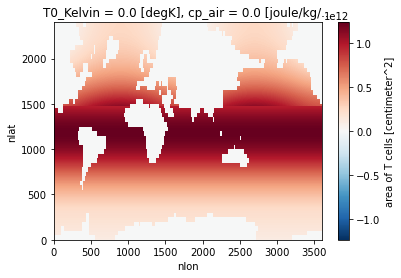

In [9]:
ds_whole.TAREA.plot()

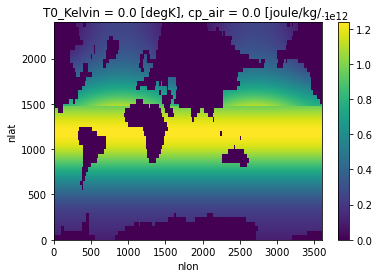

In [10]:
(ds_whole.DXT * ds_whole.DYT).plot()

In [11]:
diff = ds_whole.TAREA - (ds_whole.DXT * ds_whole.DYT)

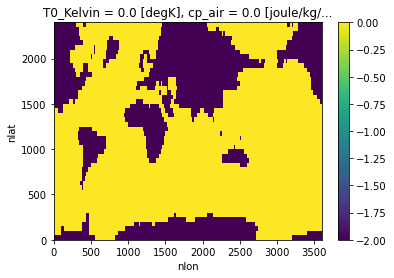

In [12]:
diff.plot()

(-0.001, 0.001)

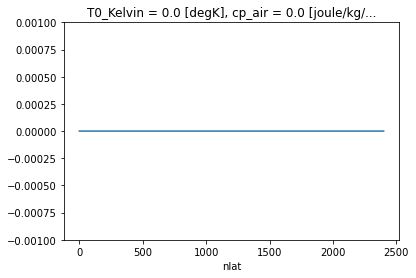

In [13]:
diff.all(dim='nlon').plot()
plt.ylim(-0.001, 0.001)

(-0.001, 0.001)

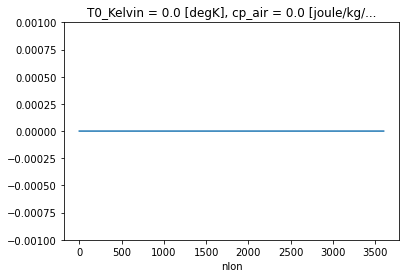

In [14]:
diff.all(dim='nlat').plot()
plt.ylim(-0.001, 0.001)

In [15]:
area = ds_whole.TAREA

## $\rho$ histogram

In [16]:
sss = ds_whole.SSS.isel(time=0)
sst = ds_whole.SST.isel(time=0)

In [17]:
rho = xr.apply_ufunc(jmd95numba.rho, sss, sst, 0,
                        output_dtypes=[sst.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load())

In [18]:
rho

<xarray.DataArray (nlat: 2400, nlon: 3600)>
dask.array<transpose, shape=(2400, 3600), dtype=float32, chunksize=(2400, 3600), chunktype=numpy.ndarray>
Dimensions without coordinates: nlat, nlon

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in rho
  return func(*(_execute_task(a, cache) for a in args))


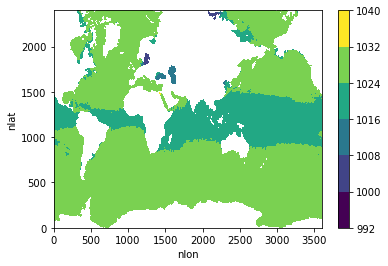

In [19]:
rho.plot.contourf()

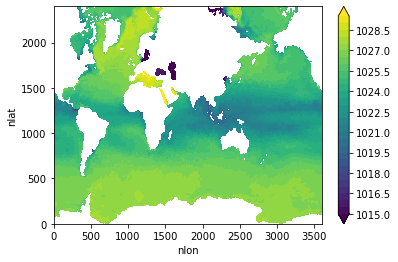

In [20]:
rho.plot.contourf(levels=np.arange(1015, 1030, 0.5))

In [34]:
delta_rho = 0.01
rho_bins = np.arange(1015, 1030, delta_rho)

In [22]:
rho_bins.size

1500

In [23]:
dens_dist = histogram(rho.rename('rho0'), bins=[rho_bins],
                         weights=area, dim=['nlon', 'nlat'])#.load()

In [24]:
sst_tend = ds.drhodt*ds.SST_bih
sss_tend = ds.drhods*ds.SSS_bih

In [25]:
tendency_terms = xr.merge([sst_tend.rename('sst_tend'), sss_tend.rename('sss_tend'),
                           ds.rho_bih.rename('dens_tend'), ds.cabbeling.rename('cabbeling_tend')])

In [26]:
all_tendencies = list(tendency_terms)

In [27]:
def histogram_func(variable):
    """Generalized xhistogram's histogram function 
    for mixing tendency terms"""
    hist = histogram(rho.rename('rho0'), bins=[rho_bins],
                     weights=variable.fillna(0.), dim=['nlat', 'nlon'])
    return hist / delta_rho

In [30]:
histograms = xr.merge([histogram_func(tendency_terms[var]).rename('OMEGA_' + var)
                      for var in all_tendencies])

In [31]:
histograms.load()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in rho
  return func(*(_execute_task(a, cache) for a in args))


<xarray.Dataset>
Dimensions:               (rho0_bin: 1499)
Coordinates:
  * rho0_bin              (rho0_bin) float64 1.015e+03 1.015e+03 ... 1.03e+03
Data variables:
    OMEGA_sst_tend        (rho0_bin) float32 -8.42e-06 4.646e-06 ... -3.848e-06
    OMEGA_sss_tend        (rho0_bin) float32 2.39e-05 2.489e-06 ... 7.119e-07
    OMEGA_dens_tend       (rho0_bin) float32 1.56e-05 7.149e-06 ... -3.108e-06
    OMEGA_cabbeling_tend  (rho0_bin) float32 -1.185e-07 -1.43e-08 ... -2.852e-08

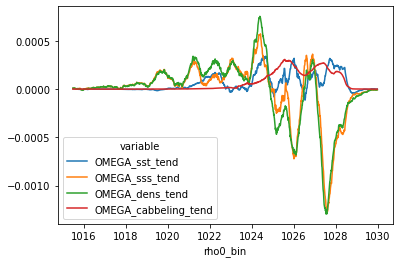

In [32]:
histograms.to_array().rolling(rho0_bin=50).mean().plot.line(hue='variable');

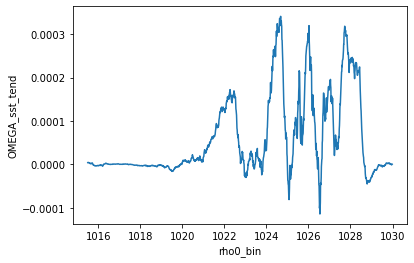

In [33]:
histograms.OMEGA_sst_tend.rolling(rho0_bin=50).mean().plot();

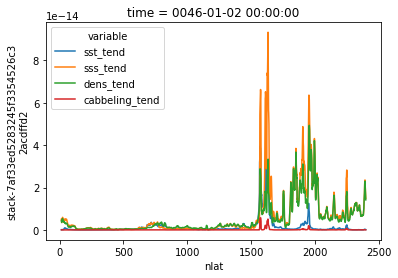

In [31]:
#Magnify the significant values by squaring to see if temp plays a bigger role than what we've seen in the above figs
(tendency_terms**2).mean('nlon').to_array().rolling(nlat=10).mean().plot.line(hue='variable');

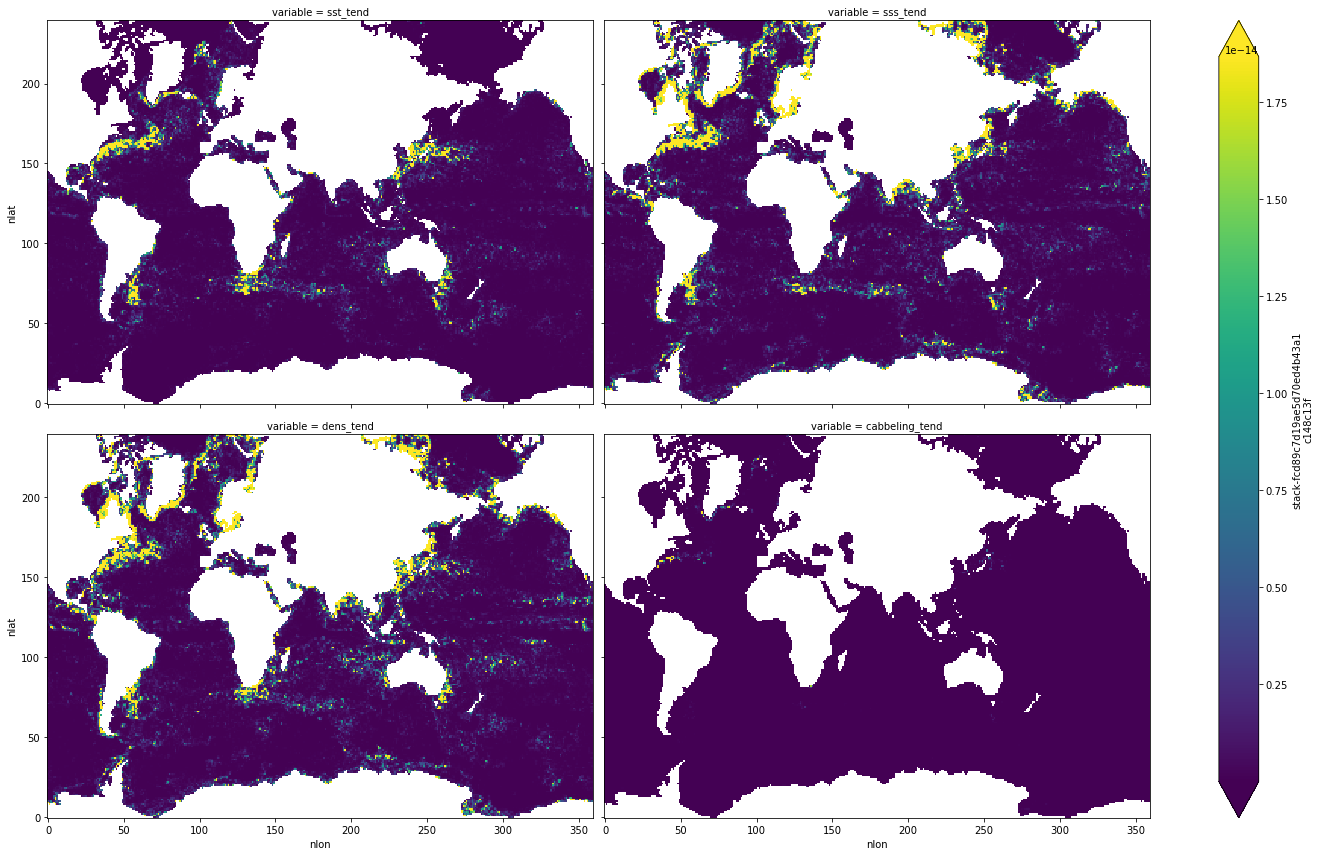

In [82]:
(tendency_terms**2).coarsen(nlon=10, nlat=10).mean().to_array().plot(col='variable', col_wrap=2, robust=True, figsize=(20, 12))

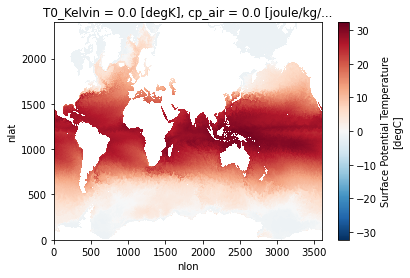

In [28]:
ds_whole.SST[0].plot()

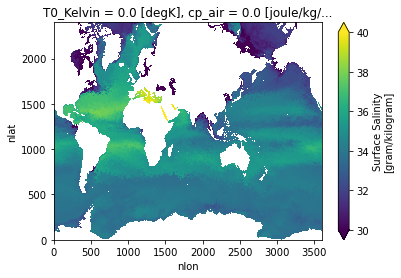

In [29]:
ds_whole.SSS[0].plot(vmin=30, vmax=40)

[Back to top](#top)

# 5) Calculate Horizontal Turner Angle for each basin <a class='anchor' id='fifth-bullet'></a>

$$Tu_h = atan2(\frac{\nabla \rho}{|\nabla \rho|} \cdot (\alpha \nabla T + \beta \nabla S), \frac{\nabla \rho}{|\nabla \rho|} \cdot (\alpha \nabla T - \beta \nabla S))$$

(Turner 1973, [Ruddick 1983](https://reader.elsevier.com/reader/sd/pii/0198014983900638?token=65952EBCA83FAAF5BF2480348931B38611B7AD90A9E27A17537E663CAF25691DF01538E4A5516463CD6E5ED33649AEEB&originRegion=us-east-1&originCreation=20220706161949), [Johnson et al., 2012](http://dx.doi.org/10.1029/2011JC007651))

- The atan() and atan2() functions calculate the arctangent of x and y/x, respectively. 
- The atan() function returns a value in the range -π/2 to π/2 radians. The atan2() function returns a value in the range -π to π radians. If both arguments of the atan2() function are zero, the function sets errno to EDOM, and returns a value of 0.

In [2]:
import json
with open('/home/jovyan/chapter2/pangeo-181919-f141378dc975.json') as token_file:
    token = json.load(token_file)
gcfs_w_token = gcsfs.GCSFileSystem(token=token)

In [3]:
tendencies = xr.open_zarr(gcfs_w_token.get_mapper('pangeo-tmp/stb2145/CESM/datasets/tendencies.zarr')).drop(['nlon', 'nlat'])
tendencies

<xarray.Dataset>
Dimensions:    (time: 182, nlat: 2400, nlon: 3600)
Coordinates:
  * time       (time) object 0046-01-02 00:00:00 ... 0046-07-02 00:00:00
Dimensions without coordinates: nlat, nlon
Data variables:
    SSS_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    cabbeling  (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhods     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    drhodt     (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    rho_bih    (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>

In [4]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
ds_unsliced  = cat["CESM_POP_hires_control"].to_dask()
ds = ds_unsliced.isel(time=slice(0,182))# slicing to just first 6mo (to match tendencies ds)

In [64]:
def horizontal_turner_angle():
    """Compute horizontal turner angle given SST and SSS"""
    
    #create grad-rho / |grad-rho| term
    rho = jmd95numba.rho(ds.SSS, ds.SST, 0)
    gradρ_modgradρ = tendencies.rho_bih / np.absolute(tendencies.rho_bih)
    
    #define alpha and beta
    runit2mass = 1.035e3 #rho_0
    alpha = - tendencies.drhodt / runit2mass
    beta = tendencies.drhods / runit2mass
    
    #create temperature and salinity components of equation
    temp_comp = alpha*tendencies.SST_bih
    salt_comp = beta*tendencies.SSS_bih
    
    #define eq
    turner_angle = np.arctan2(xr.dot(gradρ_modgradρ, (temp_comp+salt_comp)), xr.dot(gradρ_modgradρ, (temp_comp-salt_comp)))
    
    return turner_angle

In [87]:
horizontal_turner_angle().values

array(nan, dtype=float32)

In [ ]:
#create grad-rho / |grad-rho| term
rho = jmd95numba.rho(ds.SSS, ds.SST, 0)
gradρ_modgradρ = tendencies.rho_bih / np.absolute(tendencies.rho_bih)
    
#define alpha and beta
runit2mass = 1.035e3 #rho_0
alpha = - tendencies.drhodt / runit2mass
beta = tendencies.drhods / runit2mass
    
#create temperature and salinity components of equation
temp_comp = alpha*tendencies.SST_bih
salt_comp = beta*tendencies.SSS_bih
    
#define eq (w/o grad-rho / |grad-rho| term
turner_angle = np.arctan2((temp_comp+salt_comp), (temp_comp-salt_comp))

In [7]:
selection = dict(time=10, nlat=slice(1550,1650), nlon=slice(300,500))

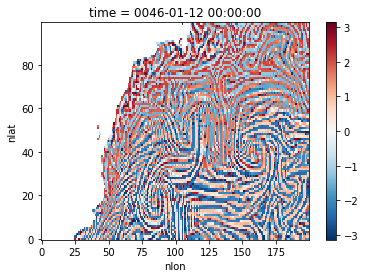

In [9]:
turner_angle.isel(**selection).plot()

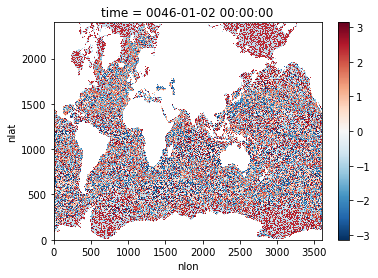

In [13]:
turner_angle[0].plot()

In [16]:
turner_angle[0,1600,600].values

array(-1.2946212, dtype=float32)

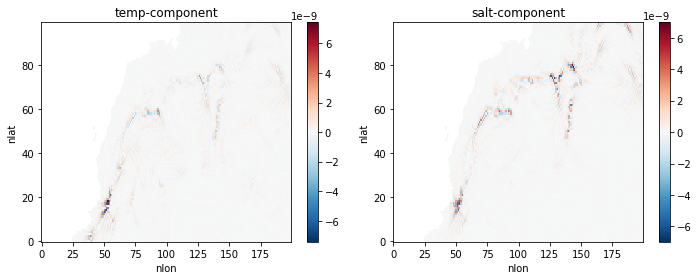

In [99]:
fig, (ax0,ax1) = plt.subplots(1, 2, figsize=(10,4))

temp_comp.isel(**selection).plot(ax=ax0)
salt_comp.isel(**selection).plot(ax=ax1)
ax0.set_title('temp-component')
ax1.set_title('salt-component')
plt.tight_layout();

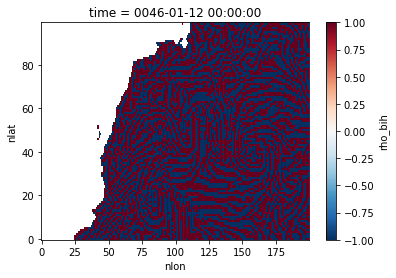

In [100]:
gradρ_modgradρ.isel(**selection).plot()

In [102]:
xr.dot(gradρ_modgradρ, (temp_comp+salt_comp)).values

array(nan, dtype=float32)

[Back to top](#top)